<a href="https://colab.research.google.com/github/StanleyLiangYork/NLP_deepLearning/blob/master/Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set up the time series pattern

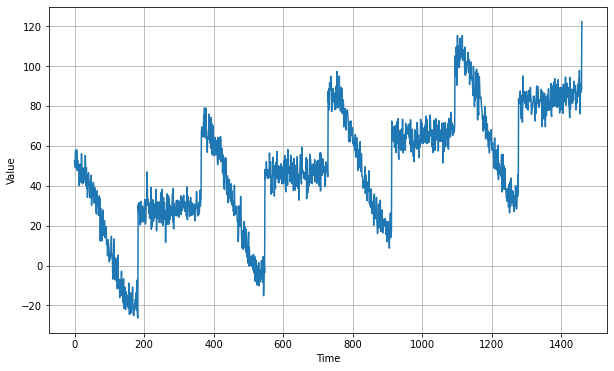

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.5,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Split the time series patterns to the training and validation set

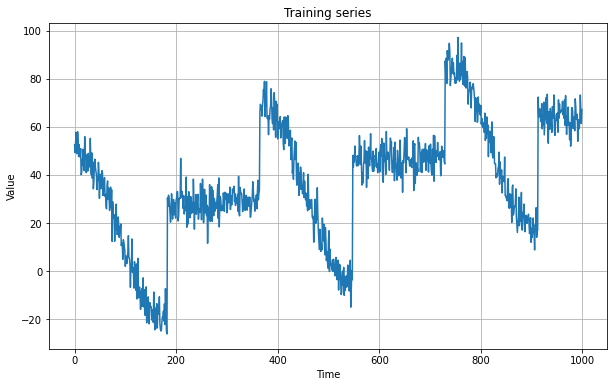

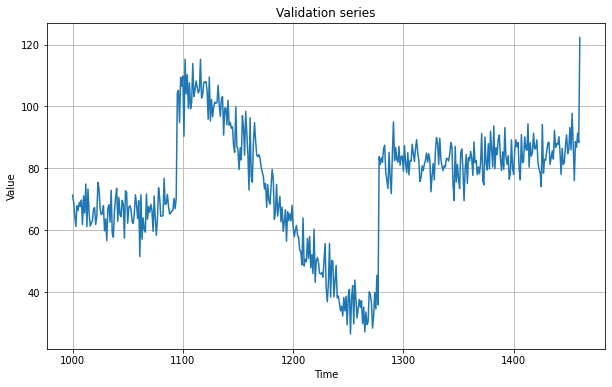

In [2]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.title("Training series")
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.title("Validation series")
plt.show()

Produce a one-uint-left shift series as the naive forecast<p>
So the prediction is relatively close to the real value

In [3]:
naive_forecast = series[split_time - 1:-1] # left shift with 1 unit of time

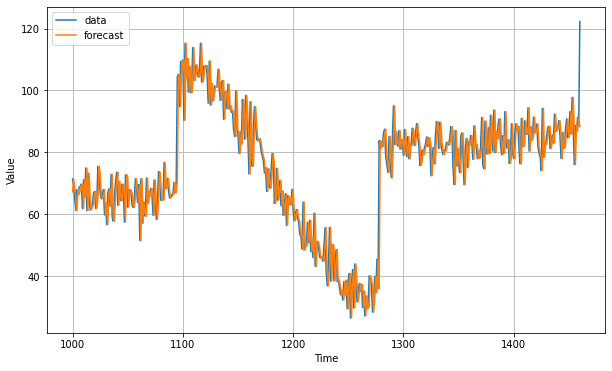

In [4]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)
plt.legend(['data','forecast'])
plt.show()

Concentrate on the 150 points on the beginning

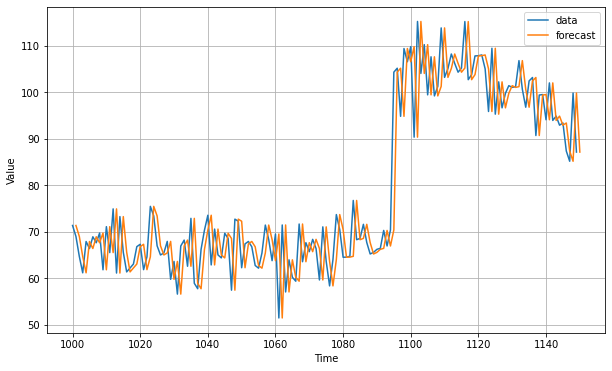

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151) # the forecast phase is 1 step behind
plt.legend(['data', 'forecast'])

compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period

In [7]:
mse = keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()
mae = keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()
print(f'MSE = {mse}, MAE = {mae}')

MSE = 62.433433532714844, MAE = 5.943365097045898


Use the mean of a given time window as the forecasts

In [8]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

Text(0.5, 1.0, 'Moving average forecast')

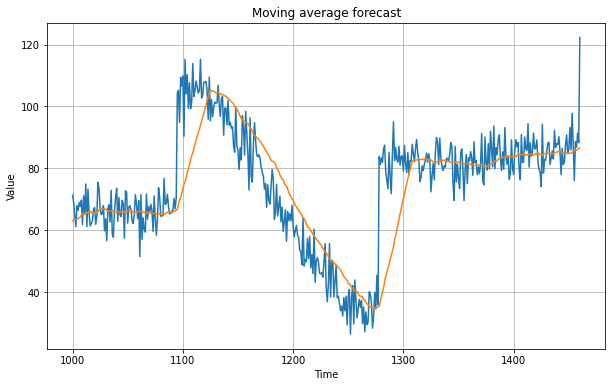

In [9]:
# use the last 30 time points to compute the mean 
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
plt.title('Moving average forecast')

In [10]:
print('smooth error')
mse = keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()
mae = keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
print(f'MSE = {mse}, MAE = {mae}') # average smoothing make the error larger

smooth error
MSE = 131.05796813964844, MAE = 7.709738731384277


Deduct the trend or seasonality pattern by subtracting the value at time t – 365 from the value at time t.

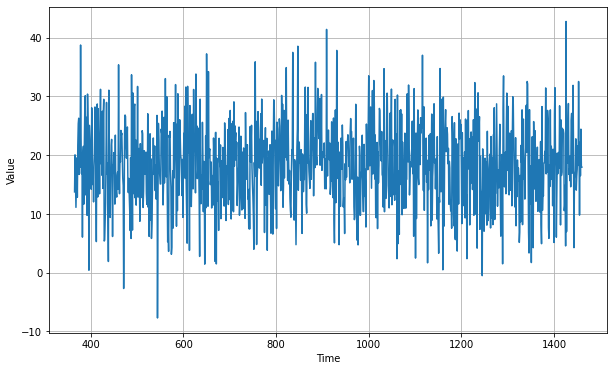

In [11]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

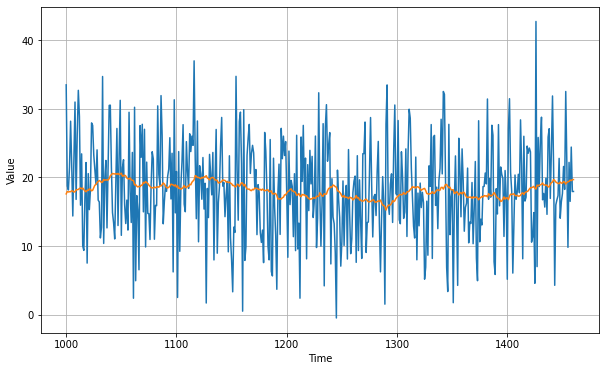

In [12]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

back the trend and seasonality

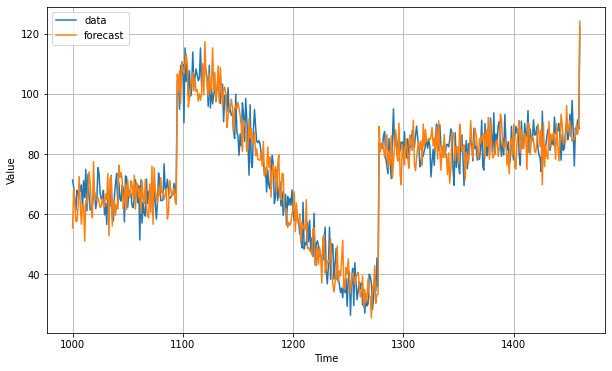

In [14]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.legend(['data','forecast'])
plt.show()

In [15]:
mse = keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy()
mae = keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()
print('Removing trend and seasonality')
print(f'MSE = {mse}, MAE = {mae}')

Removing trend and seasonality
MSE = 52.973655700683594, MAE = 5.839310646057129


Further moving the noise

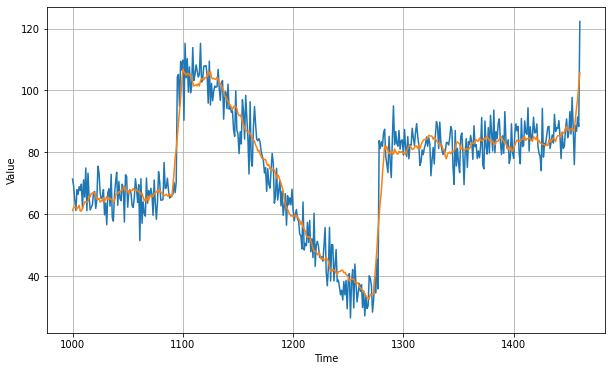

In [16]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [17]:
mse = keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()
mae = keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()
print(f'MSE = {mse}, MAE = {mae}')

MSE = 35.0646858215332, MAE = 4.662060737609863
